In [1]:
#The spelled-out intro to language modeling: building makemore(https://youtu.be/PaCmpygFfXo?si=mzPeifZrySnVlOEr)

In [2]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

#helpers
chars = ['.'] + [chr(l + ord('a')) for l in range(26)]
stoi = dict((c,i) for i,c in enumerate(chars))
itos = dict((c,i) for i,c in stoi.items())  

#create training set
def create_training_set():
    words = open('names.txt', 'r').read().split()
    
    xs = [] #training input
    ys = [] #expected output
    
    for w in words:
        chs = ['.'] + list(w) + ['.']
        for c0,c1 in zip(chs,chs[1:]):
           xs.append(stoi[c0]) 
           ys.append(stoi[c1])
           #print(c0,c1)
    
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    n = xs.nelement()
    return xs,ys,n

def create_nn():
    num_classes=len(stoi)
    g = torch.Generator().manual_seed(2147483647)
    W = torch.randn((num_classes,num_classes), generator=g, requires_grad=True) #num_classes 27 neurons(we need 27 outputs) with 27 inputs(we have an input that we will one_hot so it turns in to 27 inputs)
    return W,g

def forward(xs, W, num_classes):
    xenc = F.one_hot(xs, num_classes=num_classes).float()
    
    logits = xenc @ W

    #soft max
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    
    return probs

def calculate_loss(probs, W, ys, num):
    #average inverted log likelyhood lose

    #from the probs vector we only care about the probabilities for the target characters
    #we also add a part of W**2.mean(), this is so we can smooth the distribution by ensuring near 0 values in W
    loss = -probs[torch.arange(num),ys].log().mean() + 0.01*(W**2).mean() 

    return loss

def update(W, learning_rate):
    W.data += -learning_rate * W.grad

def evaluate(W, g, num_classes):
    g = torch.Generator().manual_seed(2147483647)

    for _ in range(10):
        out = []
        ix = 0
        while True:
            p = forward(torch.tensor([ix]), W, num_classes)  
            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            if ix == 0:
              break
            out.append(itos[ix])
        print(''.join(out))

torch.set_printoptions(precision=4, sci_mode=False)
num_classes = 27
xs,ys,n = create_training_set()
print(f'training set has {n} examples')

W,g = create_nn()
probs = forward(xs,W, num_classes)#ypred
loss = calculate_loss(probs, W, ys, n)
print(f'initial loss = {loss.item()}')

for i in range(800):
    #forward
    probs = forward(xs,W, num_classes)#ypred
    loss = calculate_loss(probs, W, ys, n)
    
    #backward
    W.grad = None
    loss.backward()
    
    update(W, 400 / (1.0 + i))

print(f'final loss = {loss.item()}')

evaluate(W, g, num_classes)

training set has 228146 examples
initial loss = 3.7686190605163574
final loss = 2.511305570602417
junide
janasah
pxzfay
a
nn
kohin
tolian
jgee
ksaheiauyanilevias
dbdainrwieta


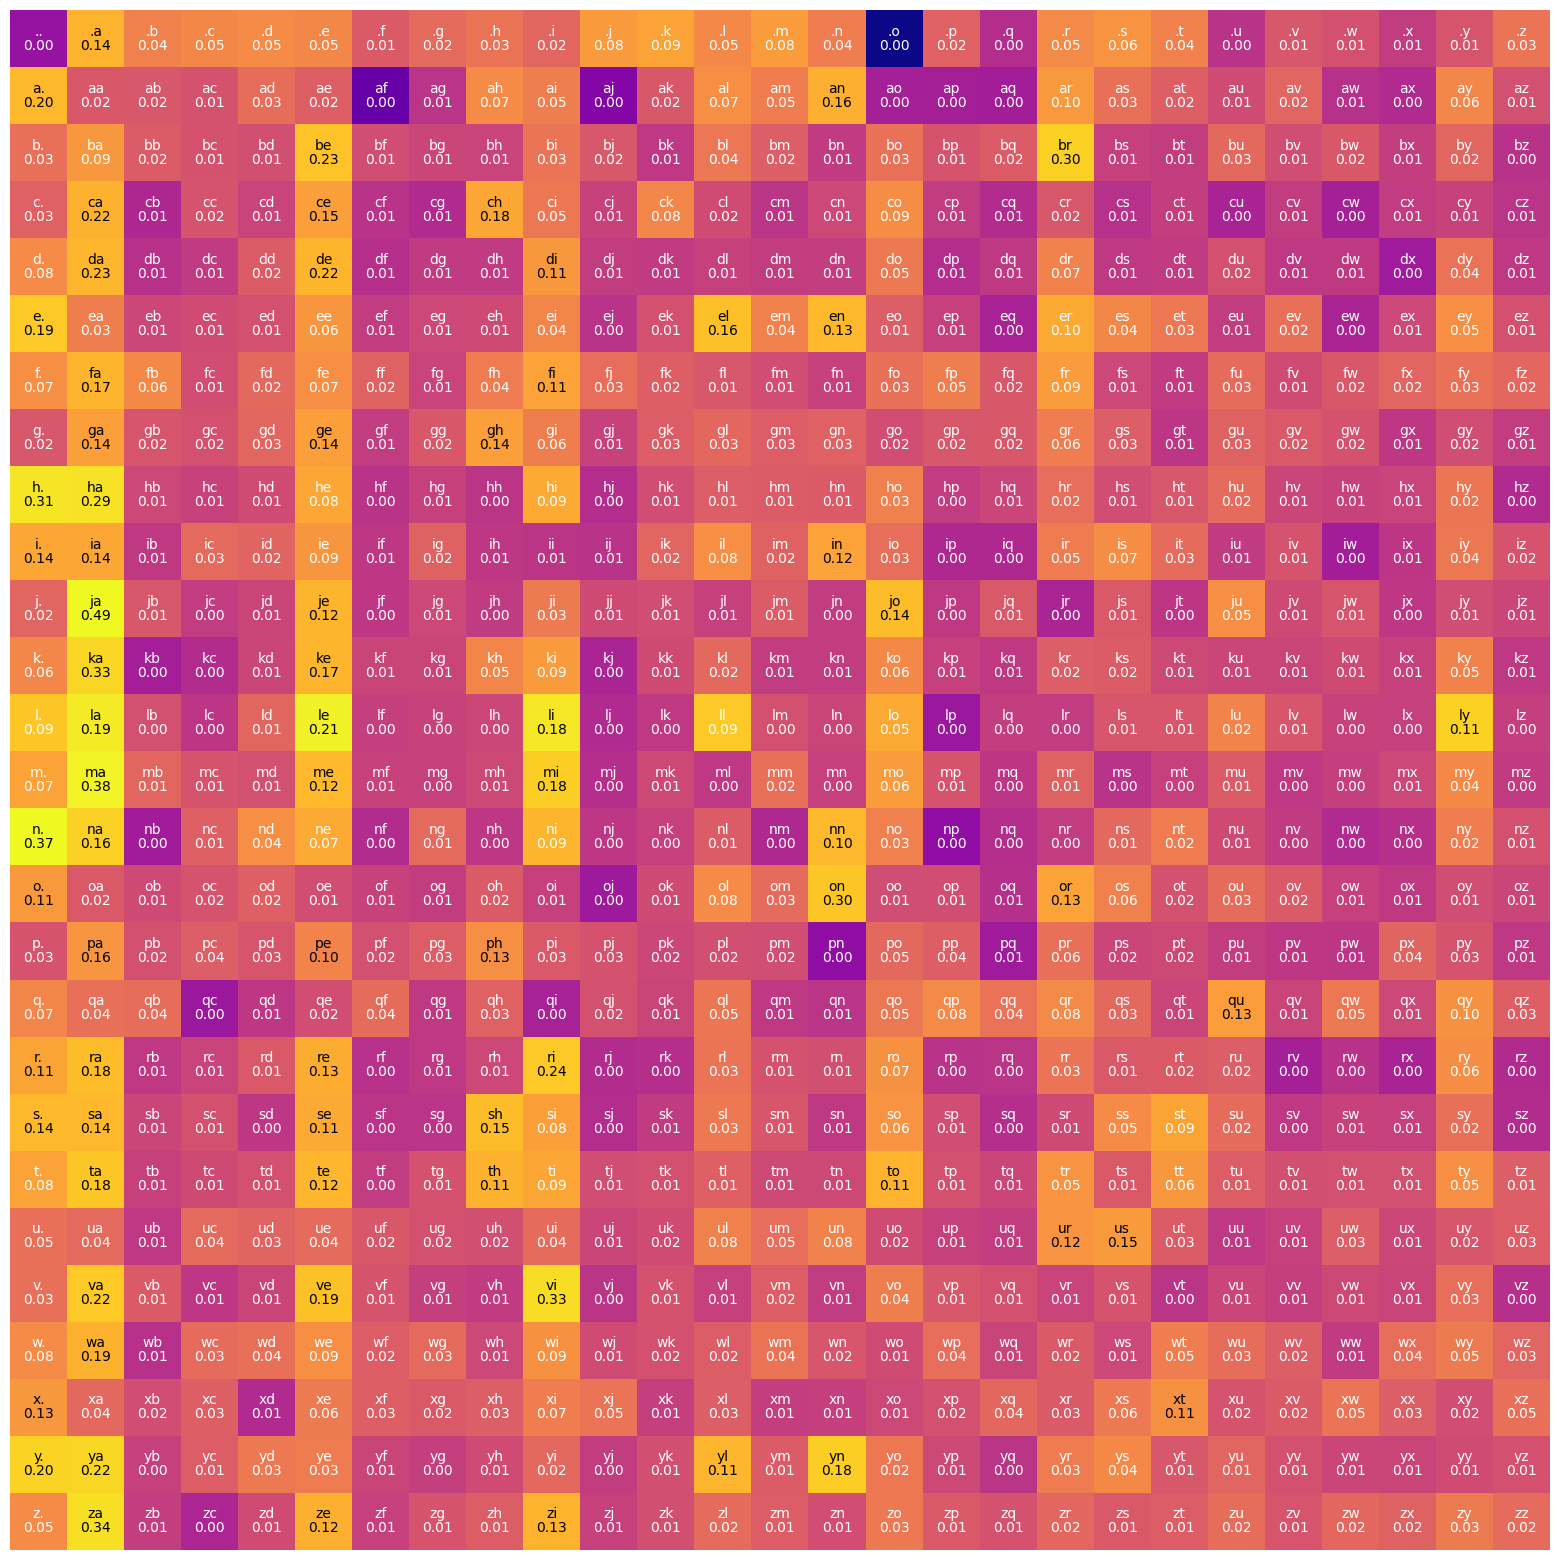

In [3]:
from matplotlib import pyplot as plt

distribution = W.detach()

#softmax
P = distribution.exp()
P /= P.sum(1, keepdim=True)

plt.figure(figsize=(20,20))
plt.imshow(distribution, norm = 'linear', cmap = 'plasma')
plt.axis('off')
for c0 in range(27):
    for c1 in range(27):
        c0s = itos[c0]
        c1s = itos[c1]
        c0c1 =  c0s + c1s
        value = P[c0,c1].item()
        plt.text(c1, c0, c0c1, ha='center', va='bottom', color='white' if value < 0.1 else 'black')
        plt.text(c1, c0, f'{value:.2f}', ha='center', va='top', color='white' if value < 0.1 else 'black')

In [4]:
import torch

#helpers
chars = ['.'] + [chr(l + ord('a')) for l in range(26)]
stoi = dict((c,i) for i,c in enumerate(chars))
itos = dict((i,c) for c,i in stoi.items())  

def counting_example_on_same_data():
    def create_model():
        words = open('names.txt', 'r').read().split()

        distribution = torch.zeros((28,28), dtype=torch.int32)
        
        for w in words:
            chs = ['.'] + list(w) + ['.']
            for c0,c1 in zip(chs,chs[1:]):
                distribution[stoi[c0],stoi[c1]] +=1
        return distribution,words

    def prediction(distribution):
        P = (distribution + 1).float() # the +1 is because we smooth the distribution, we don't want to have -inf average_log_likelyhood_loss for anything
        P /= P.sum(1, keepdim=True)
        
        g = torch.Generator().manual_seed(2147483647)
        
        for i in range(10):
            out = []
            ix = 0
            while True:
                ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=g).item()
                #print(ix)
                if ix == 0:
                    break
                out.append(itos[ix])
            print(''.join(out))

    def average_log_likelyhood_loss(words, probability_matrix):
        log_likelyhood_out = 0
        n = 0
        for w in words:
            for c0,c1 in zip(w,w[1:]):
                p = probability_matrix[stoi[c0],stoi[c1]]
                log_p = torch.log(p)
                log_likelyhood_out += log_p
                n += 1
        return -log_likelyhood_out / n
        
    distribution,words = create_model()
    prediction(distribution)
    P = (distribution + 1).float()
    P /= P.sum(1, keepdim=True)
    print(f'loss = {average_log_likelyhood_loss(words, P)}')
    return distribution
    
distribution_c = counting_example_on_same_data()

junide
janasah
p
cony
a
nn
kohin
tolian
juee
ksahnaauranilevias
loss = 2.514045476913452


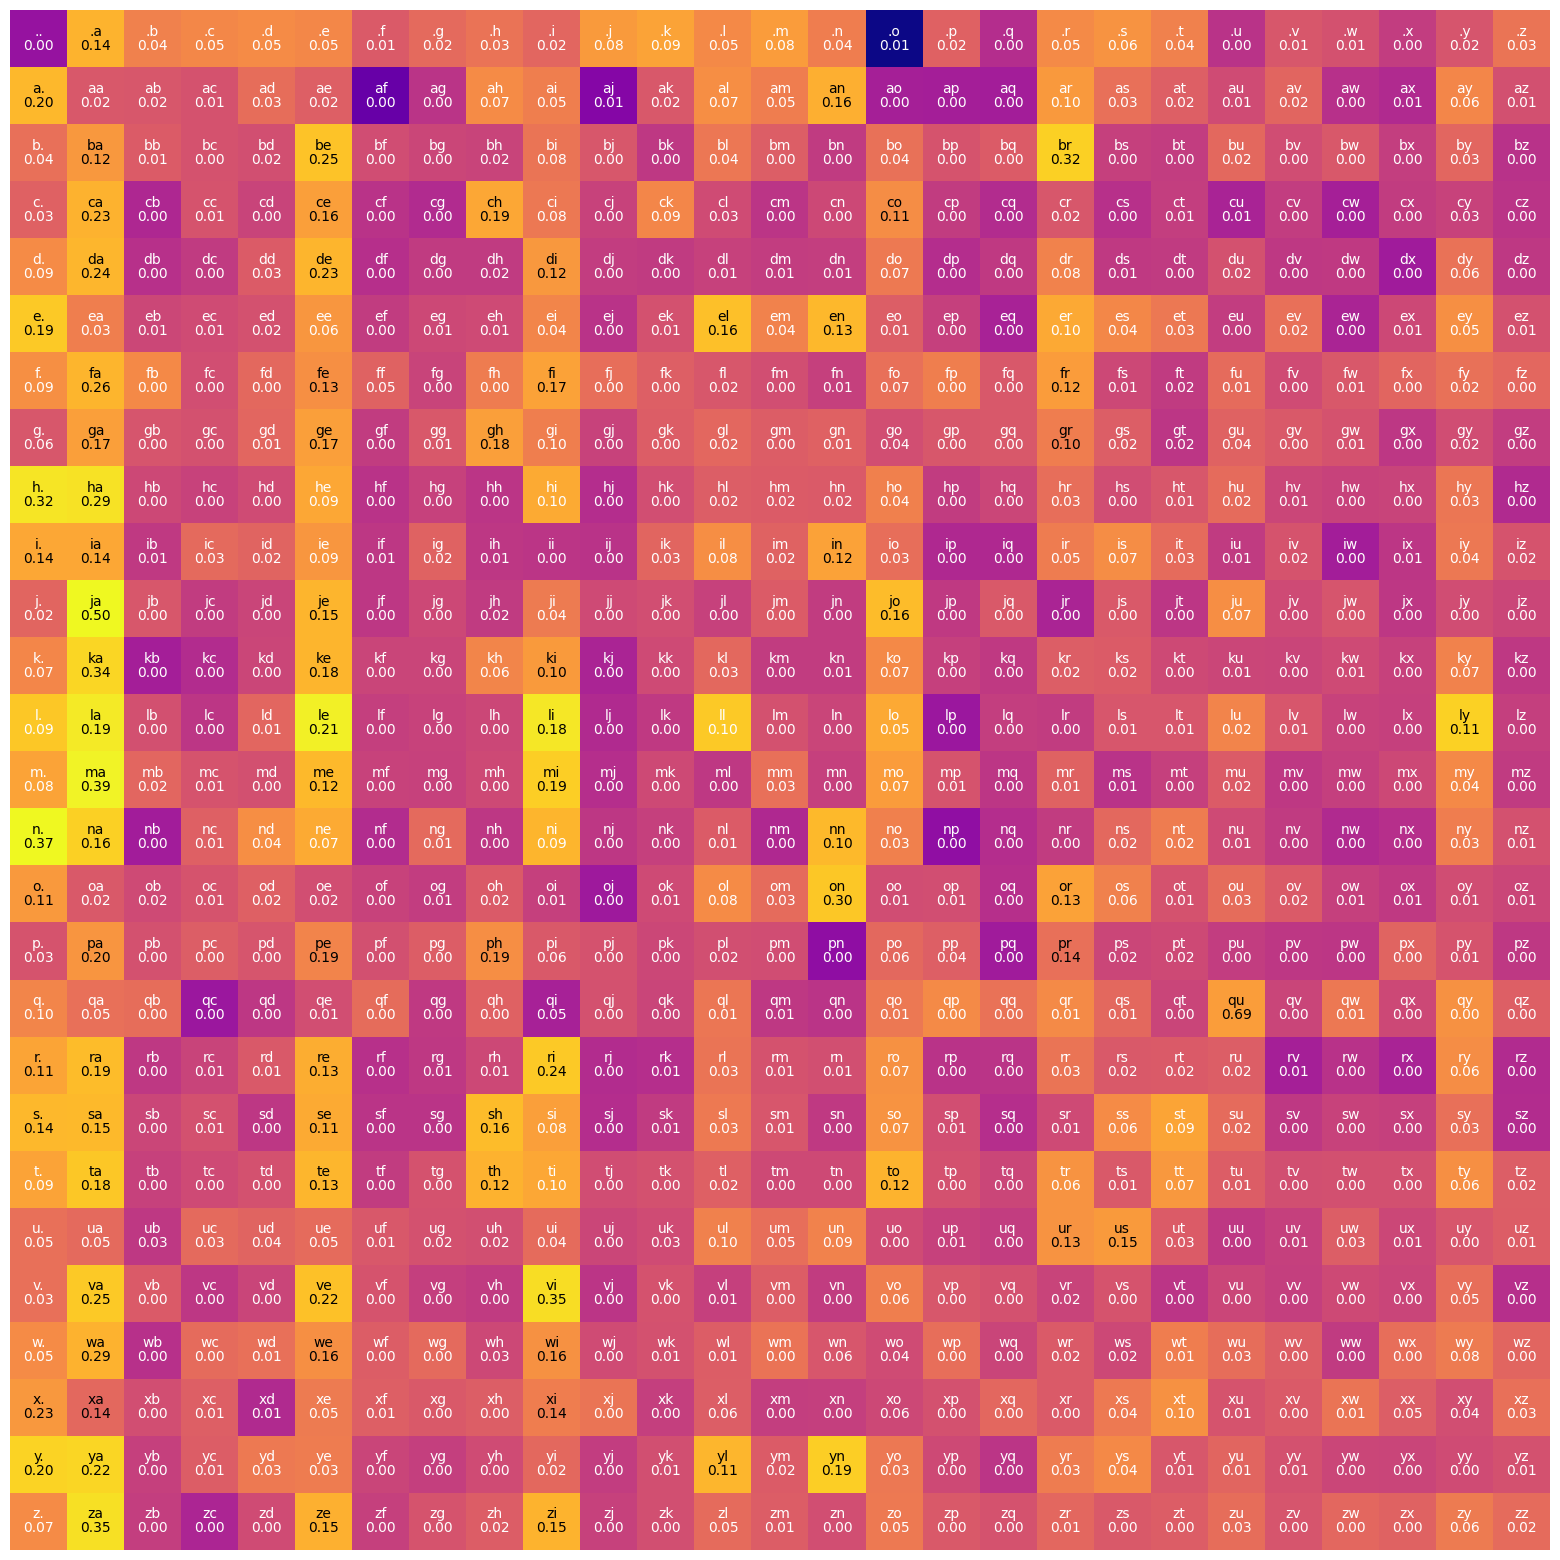

In [5]:
from matplotlib import pyplot as plt

#softmax
P = (distribution_c + 1).float()
P /= P.sum(1, keepdim=True)

plt.figure(figsize=(20,20))
plt.imshow(distribution, norm = 'linear', cmap = 'plasma')
plt.axis('off')
for c0 in range(27):
    for c1 in range(27):
        c0s = itos[c0]
        c1s = itos[c1]
        c0c1 =  c0s + c1s
        value = P[c0,c1].item()
        plt.text(c1, c0, c0c1, ha='center', va='bottom', color='white' if value < 0.1 else 'black')
        plt.text(c1, c0, f'{value:.2f}', ha='center', va='top', color='white' if value < 0.1 else 'black')